In [1]:
import re
import glob
from IPython.core.display import Image

# A Practical View of Spectrum Sensing Methods

*Tomaž Šolc*

Jožef Stefan Institute  
Jamova 39, 1000 Ljubljana, Slovenia

*tomaz.solc@ijs.si*

## Introduction

### Measurement setup

*(cf. notebook p. 697)*

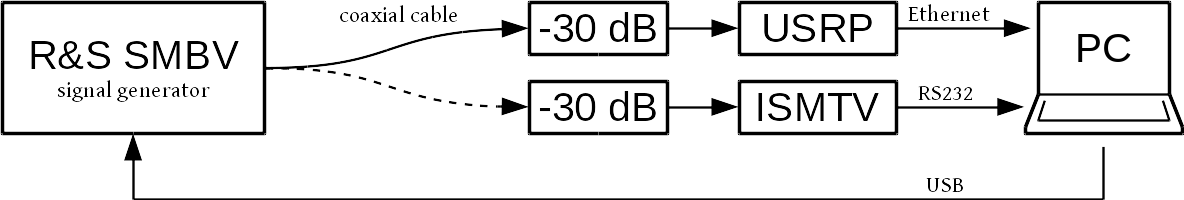

In [2]:
Image(filename='figures/experiment-setup.png', width="100%")

* Rohde & Schwarz SMBV100A vector signal generator,
   - Analog FM modulation set up with IEEE Soft Speaker wireless microphone model,
   - ARB mode for noise generation
   
* Mini-Circuits 50 ohm 30 dB attenuator,

* coaxial cable
 - 60 cm LMR-195 ULTRAFLEX
 - connected as shown by solid line for measurements using USRP,
 - connected as shown by dashed line for measurements using SNE-ISMTV
* USRP N200 with SBX daughterboard
 - Motherboard: N200r4 (F4B959)
 - Daughterboard: SBX (F4D075, TX/RX, A:0)
 - mid-point gain of 19.0 dB
* VESNA sensor node
 - Sensor Node Core VESNA-SNC-STM32 V1.1.1-240412-01085
 - Sensor Node Expansion SNE-ISMTV-UHF V1.1.3-proto-00005
 - vesna-spectrum-sensor firmware, version 846f8c
* laptop

### Methods evaluated

In the following, each method is marked with an abbreviation as follows:

* **ED** energy detector,
* **CAV** covariance absolute value,
* **CFN** covariance Frobenius norm,
* **MAC** maximum auto-correlation,
* **MME** maximum-to-minimum eigenvalue detector,
* **EME** energy to minimum eigenvalue detector,
* **AGM** arithmetic to geometric mean detector and
* **MET** maximum eigenvalue to trace detector.
* **SCF** cyclostationary detector using spectral correlation function.

### Choice of USRP sampling settings

Three settings for the USRP were chosen:

* $t_s$ = 25.0 ms, $f_s$ = 1 MHz, $N_s$ = 25 kSamples

  Low-end embedded profile. Limited by the ADC performance and available RAM for ADC buffer. This is expected to be the maximum performance using single 1 MHz ADC on a STM32 microcontroller with 100 kB of RAM.
  
* $t_s$ = 12.5 ms, $f_s$ = 2 MHz, $N_s$ = 25 kSamples

  High-end embedded profile. Limited by the ADC performance and available RAM for ADC buffer. This is expected to be the maximum performance using dual 1 MHz ADC in interleaved mode on a STM32 microcontroller with 100 kB of RAM.
  
* $t_s$ = 10.0 ms, $f_s$ = 10 MHz, $N_s$ = 100 kSamples

  Profile for a high-performance CPU and SDR front-end.

### Choice of SNE-ISMTV sampling settings

SNE-ISMTV contains an analog energy detector. Sampling rate is fixed at $f_{sSNE}$.



In [3]:
fsSNE = 1/6.8e-6

print("fsSNE = ", fsSNE)

fsSNE =  147058.82352941178


To get comparable results with the USRP measurements, the number of samples was chosen so that the sensing time with SNE was approximately equal to the USRP sensing time.

In [4]:
ts = array([25.0e-3, 12.5e-3, 10.0e-3])

NsSNE = numpy.round(ts*fsSNE)
print("NsSNE =", NsSNE)

NsSNE = [ 3676.  1838.  1471.]


### Choice of signal waveform

The signal we attempted to detect was the IEEE Wireless Microphone simulation method, using the Soft Speaker profile.

IEEE Wireless Microphone simulation method simulates a transmission from a analog FM wireless microphone using an FM modulated sine wave:

$x(t) = A\cos\left[2\pi f_c t + 2 \pi \Delta f \int_0^t sin\left( 2\pi f_m u du\right) \right]$

$\Delta f = 15 \mathrm{kHz}$

$f_m = 3.9 \mathrm{kHz}$

The carrier frequency $f_c$ was 864 MHz for USRP (frequency for unlicensed operation of wireless microphones in Europe) and 850 MHz for SNE-ISMTV (frequency nearest to 864 MHz supported by the hardware).

### Measuring signal attenuation

Total attenuation in the cable, connectors and the 30 dB attenuator was measured using a R&S FSV spectrum analyzer. All equipment was left to warm-up for at least 2 hours before all measurements.

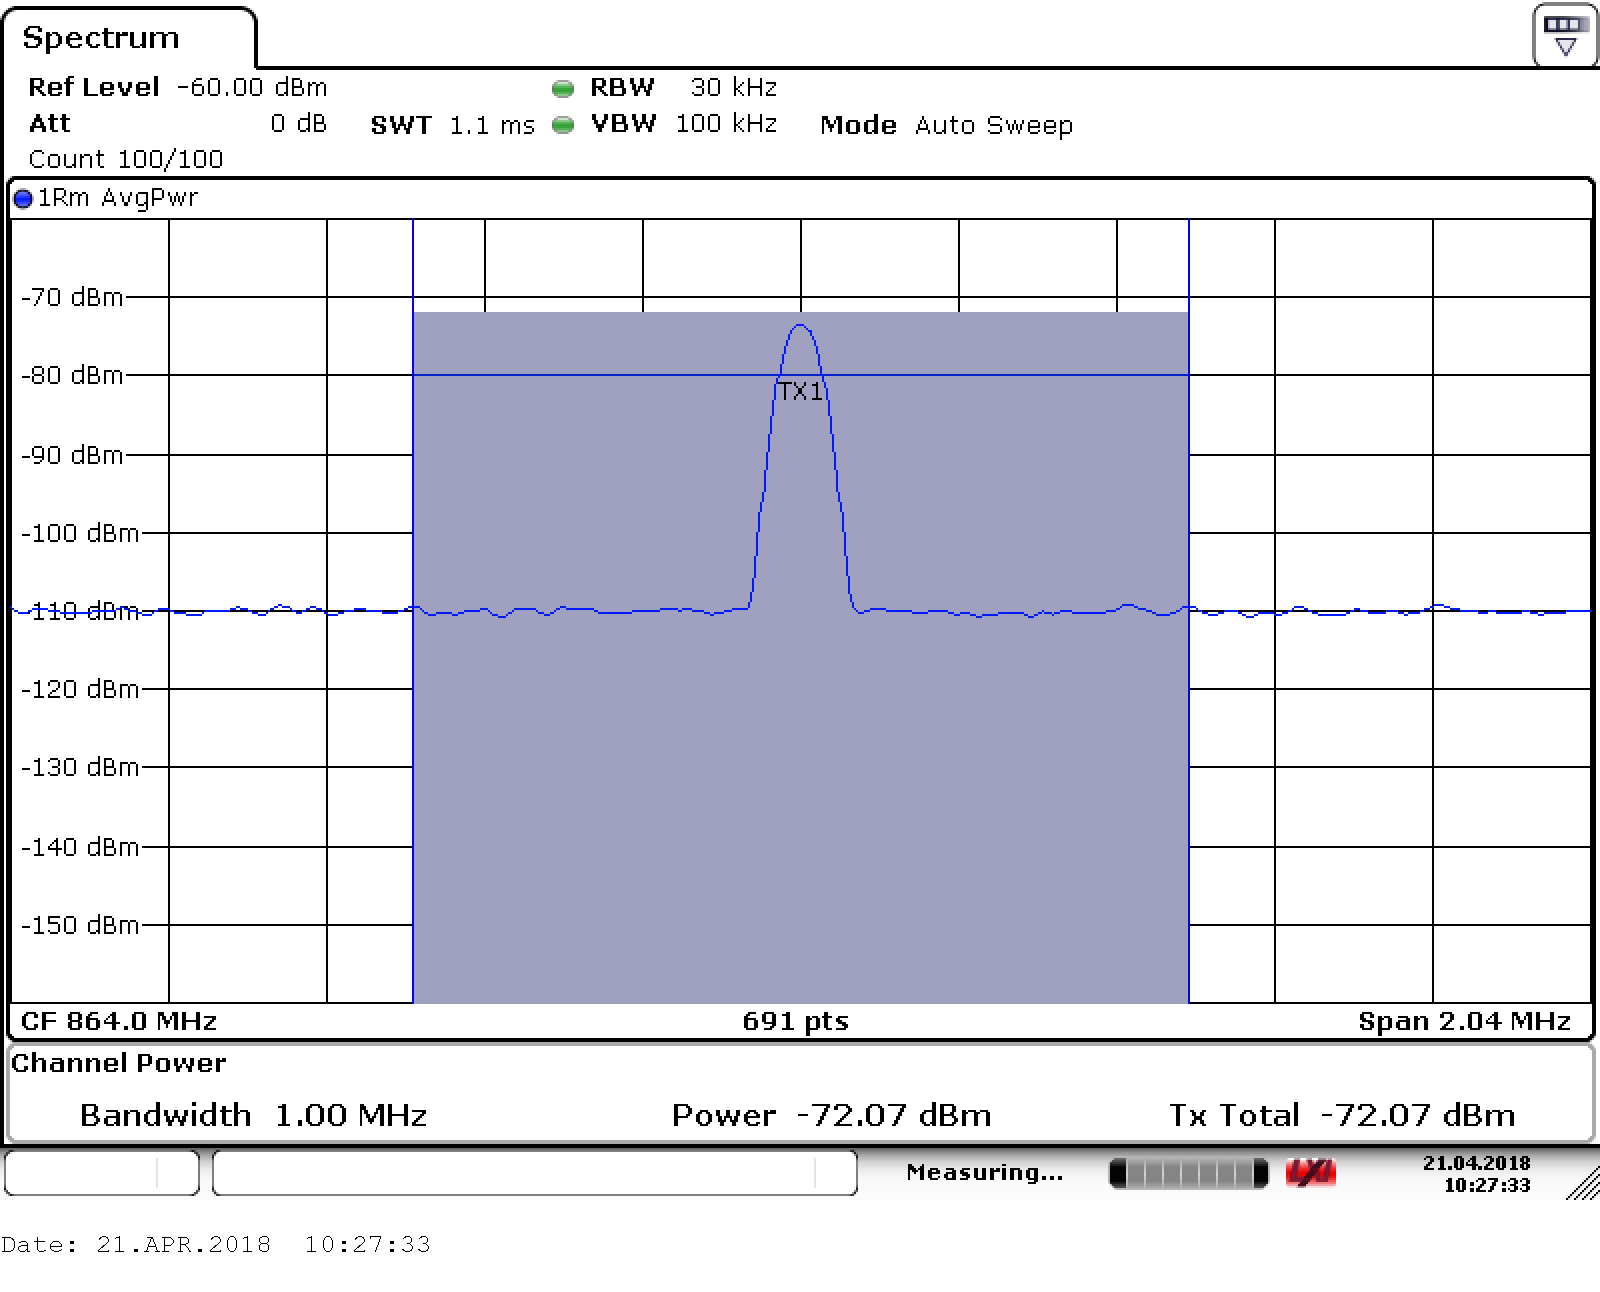

In [5]:
Image(filename='figures/power_measurement.png', width="100%")

Figure above shows input power measured by the signal analyzer when the signal generator output is was set to -40 dBm.

In [6]:
Att = 72.07 - 40
print("Att =", Att, "dBm")

Att = 32.06999999999999 dBm


## Comparison of probability of detection $P_d$

In this experiment we measured the lowest signal power $P_{in}$ detectable with a spectrum sensing method at a chosen minimum probability of detection $P_{dmin}$.

In [7]:
Pdmin = 0.9

Since in this controlled laboratory setup the noise power $P_{noise}$ remains constant for the chosen hardware configuration, the signal power directly relates to the signa-to-noise ratio (SNR)

$SNR = \frac{P_{in}}{P_{noise}}$

Here we assume that the coaxial cable and all equipment is well shielded, so that is no external interference. We also assume that the temperature and other factors affecting internal receiver noise do not change during the course of the experiment.

### Calculating threshold

Before we can determine the probability of detection for a method we have to calcuate its detection threshold $\gamma_0$. 

A probability of false alarm $P_{fa}$ was chosen.

In [8]:
Pfa = 0.1

Given $P_{fa}$ we can determine $\gamma_0$ from $\gamma$ complementary cumulative density function (CCDF) for the given detector with no input signal.

To measure the distribution of $\gamma$, the RF output of the generator was switched off and $N_p$ measurements of $\gamma$ taken for each of the chosen detectors.

In [9]:
Np = 1000

Given these measurements we approximate the CCDF and determine the value of $\gamma_0$ by interpolation.

In [10]:
def get_ccdf(x):
    
    xs = array(x)
    xs.sort()
    N = float(len(xs))
    P = arange(N)/N
    
    return xs, P

def get_gamma0(gammaN):
    
    gammaN, Pd = get_ccdf(gammaN)
    gamma0 = interp(1. - Pfa, Pd, gammaN)
    
    return gamma0

For example, energy detector using USRP with $f_s=1\mathrm{MHz}$ and $N_s=25000\mathrm{samples}$ yields the following value for the threshold:

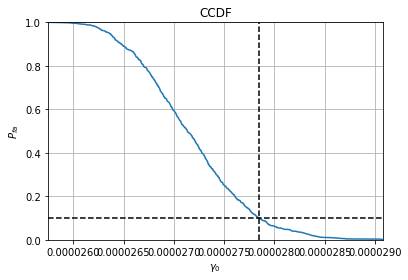

In [11]:
ex_path = "../measurements/pd/usrp/sim_usrp_micsoft_fs1mhz_Ns25ks_ed"
#ex_path = "../measurements/pd/usrp/sim_usrp_micsoft_fs1mhz_Ns25ks_met_l5"
#ex_path = "../measurements/pd/sneismtv/sim_sneismtv_micsoft_fs0mhz_Ns3ks_ed_n3676")
#ex_path = "../measurements/pd/sneismtv/sim_sneismtv_micsoft_fs0mhz_Ns3ks_ed_n1838")

gammaN = loadtxt(ex_path + "_off.dat")
gamma0 = get_gamma0(gammaN)

gammaNs, Pd = get_ccdf(gammaN)
plot(gammaNs, 1.-Pd)
plot([gamma0, gamma0], [0, 1], 'k--')
plot([gammaNs[0], gammaNs[-1]], [Pfa, Pfa], 'k--')
axis([gammaNs[0], gammaNs[-1], 0, 1])
title("CCDF")
xlabel("$\gamma_0$")
ylabel("$P_{fa}$")
grid()

In [12]:
print("gamma0 =", gamma0, "@ Pfa =", Pfa)

gamma0 = 2.7851381673826836e-05 @ Pfa = 0.1


### Calculating probability of detection

To determine how the probability of detection changes with SNR, the signal generator was swept through a number of power settings. For each generator power setting $P_g$, $N_p$ measurements of $\gamma$ were taken for each of the chosen spectrum sensing methods.

In [13]:
def iterate_campaign(path):
    for fn in glob.glob(path):
        g = re.search("_m([0-9_]+)dbm\.dat$", fn)
        if g:
            Pg = -float(g.group(1).replace('_', '.'))
            gamma = loadtxt(fn)
            
            yield Pg, gamma

print("Pg =", array(sorted(Pg for Pg, gamma 
        in iterate_campaign("../measurements/pd/usrp/sim_usrp_micsoft_fs1mhz_Ns25ks_ed_*.dat"))))

Pg = [-100.  -99.  -98.  -97.  -96.  -95.  -94.  -93.  -92.  -91.  -90.  -89.
  -88.  -87.  -86.  -85.  -84.  -83.  -82.  -81.  -80.  -79.  -78.  -77.
  -76.  -75.  -74.  -73.  -72.  -71.]


If $P_g$ is the output power of the calibrated signal generator, then

$P_{in}$ = $P_g$ - $A$

Probability of detection $P_d$ is calculated for each $P_{in}$ and each method by counting the number of $\gamma$ measurements that were above the calculated threshold $\gamma_0$.


In [14]:
from scipy.special import betaincinv

Pconf = 1 - 1e-6

def confint(n1, n0):
    
    mle = n1/float(n1+n0)
    
    if n1 == 0:
        u = 0.
        v = betaincinv(n1+1, n0+1, Pconf)
    elif n0 == 0:
        u = betaincinv(n1+1, n0+1, 1. - Pconf)
        v = 1.
    else:
        u = betaincinv(n1+1, n0+1, .5 - Pconf/2.)
        v = betaincinv(n1+1, n0+1, .5 + Pconf/2.)
    
    return mle, u, v

def get_campaign_g(path, gamma0):
    Pg = []
    Pd  = []
    
    for Pg0, gamma in iterate_campaign(path):
        Pg.append(Pg0)
        
        N1 = sum(gamma > gamma0)
        N0 = sum(gamma <= gamma0)
        
        #print N1, N0
        
        Pdmle, Pdmin, Pdmax = confint(N1, N0)      
        Pd.append((Pdmle, Pdmin, Pdmax))
            
    Pg = array(Pg)
    Pd = array(Pd)
        
    Pga = Pg.argsort()
    Pd = Pd[Pga]
    Pg = Pg[Pga]
    
    return Pg, Pd
            
def get_campaign(path, gamma0):
    Pg, Pd = get_campaign_g(path, gamma0)
    
    Pin = Pg - Att
    
    return Pin, Pd

def get_Pinmin(path, Pdth=Pdmin):
    
    gamma0 = None
    
    for fn in glob.glob(path):
        if fn.endswith("_off.dat"):
            gammaN = loadtxt(fn)
            gamma0 = get_gamma0(gammaN)
            break
            
    Pin, Pd = get_campaign(path, gamma0)
    
    # We did not see Pd cross the threshold.
    if (amin(Pd[:,0]) > Pdth) or (amax(Pd[:,0]) < Pdth):
        return 0, 0, Pin[-1]
    
    Pinminmle = interp(Pdth, Pd[:,0], Pin)
    
    # note: upper limit for Pd results in lower limit for Pinmin!
    Pinminmin = interp(Pdth, Pd[:,2], Pin)
    Pinminmax = interp(Pdth, Pd[:,1], Pin)
    
    return Pinminmle, Pinminmin, Pinminmax

Given minimum $P_d$, $P_{dmin}$, the minimum signal power $P_{inmin}$ for the spectrum sensing method can be determined from measurements using interpolation.

For example, for energy detector using USRP:

In [15]:
Pinmin, u, v = get_Pinmin(ex_path + "_*.dat")
print("Pinmin =", Pinmin, "@ Pdmin =", Pdmin)

Pinmin = -118.21084507042252 @ Pdmin = 0.9


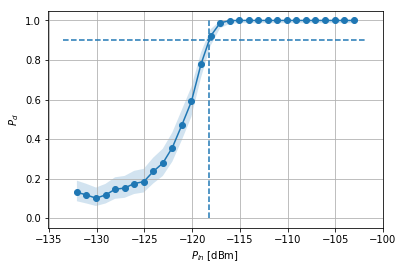

In [16]:
Pin, Pd = get_campaign(ex_path + "_*.dat", gamma0)

fill_between(Pin, Pd[:,1], Pd[:,2], edgecolor='none', facecolor='C0', alpha=.2)
plot(Pin, Pd[:,0], 'o-')
plot([Pinmin, Pinmin], [0, 1], 'C0--')
x1, x2, y1, y2 = axis()
plot([x1, x2], [Pdmin, Pdmin], 'C0--')
xlabel("$P_{in}$ [dBm]")
ylabel("$P_d$")
grid()

In [17]:
i = int(interp(Pdmin, Pd[:,0], arange(len(Pd))))
print("Interpolated: %f (d=%f)" % (Pinmin, v-u))

Interpolated: -118.210845 (d=0.793544)


### Comparing minimum detectable power

Comparing $P_{inmin}$ for different methods.

Covariance based method were tested with different smoothing factors $L \in \{5, 10, 15, 20\}$

In [18]:
method_ps = set()
for path in glob.glob("../measurements/pd/usrp/sim_usrp_micsoft_*.dat"):
    g = re.search("ks_(.*)_m", path)
    if g:
        method_ps.add(g.group(1))
        
assert len(method_ps) > 0
        
method_ps = sorted(method_ps)

In [19]:
def get_batch_Pinmin_permethod(path, Pdth=Pdmin):
    Pinmin_permethod = {}
    for method_p in method_ps:
        path2 = path.replace("*", "%s_*" % (method_p,))
        Pinmin_permethod[method_p] = get_Pinmin(path2, Pdmin)
        
    return Pinmin_permethod

In [20]:
from matplotlib import cm

def plot_comparisson(Pinmin_permethod, noisecomp=False):
    
    cmap = cm.get_cmap('gist_rainbow')

    left = []
    yerr = [[],[]]
    height = []
    labels = []
    data_labels = []
    colors = []

    methods = ['ed', 'cav', 'cfn', 'mac', 'mme', 'eme', 'agm', 'met', 'scf']

    left1 = 0.
    for n, method in enumerate(methods):
        if method == 'ed':
            method_ps = [ 'ismtv', 'ed']
        elif method == 'scf':
            method_ps = ["scf_Np%d" % scfNp for scfNp in [64, 128]]
        else:
            if noisecomp:
                # compensated detectors
                method_ps = [ "c%s_l%d" % (method, l) for l in range(5, 25, 5) ]
            else:
                # uncompensated detectors
                method_ps = [ "%s_l%d" % (method, l) for l in range(5, 25, 5) ]
        
        for m, method_p in enumerate(method_ps):
            try:
                Pinmin, u, v = Pinmin_permethod[method_p]
            except KeyError:
                continue
        
            left.append(left1)
            
            if Pinmin == 0:
                height.append(-100)
                data_labels.append("> %.1f" % v)
                yerr[0].append(0)
                yerr[1].append(0)            
            else:
                height.append(Pinmin)
                data_labels.append("%.1f" % Pinmin)
                yerr[0].append(Pinmin-u)
                yerr[1].append(v-Pinmin)
        
            if method_p == 'ed':
                label = 'ED (USRP)'
            elif method_p == 'ismtv':
                label = 'ED (ISMTV)'
            else:
                label = method_p.upper()
                label = re.sub("C(\w\w\w)_L", r"\1_L", label)
                label = re.sub("_L(\d+)", r" $L=\1$", label)
                label = re.sub("_NP(\d+)", r" $N'=\1$", label)

            labels.append(label)
        
            c = cmap(float(n)/(len(methods)-1) + m*.007)
            # Color
            #colors.append(c)
            
            # BW
            #colors.append((.85,.85,.85))
            colors.append((0.851, 0.796, 0.765))
            
            #if len(left) < 3:          
            #    colors.append('#729fcf')
            #elif len(left) < 15:
            #    colors.append('#fce94f')
            #elif len(left) < 31:
            #    colors.append('#8ae234')
            #else:
            #    colors.append('#ad7fa8')
            
            left1 += 1.
        
        left1 += .9
    
    height = array(height)
    left = array(left)
    yerr = array(yerr)

    # print
    #figure(figsize=(13, 5))
    
    # screen
    figure(figsize=(12, 5))
    
    for x, y, e, l in zip(left, height, yerr[0,:], data_labels):
            
        text(x+.4, y-e-1.5, l, horizontalalignment="center", rotation=80, 
                bbox=dict(boxstyle='square', fc='w', ec='none'))
        
        
    #o = 100
    #bar(left, -height-o, color=colors, bottom=o)
    bw = .8
    bar(left+bw/2, height, color=colors, width=bw, lw=1, ls='solid', ec='k')
    errorbar(left+bw/2., height, yerr=yerr, ls='none', color='k', capsize=4., lw=1)
    
    xticks(left+bw/2, labels, rotation=60, horizontalalignment='right')
    ylabel("$P_{in}$ [dBm] @ $P_d = 0.9$")
    #ylim(100, 118)
    ylim(-130, -100)
    xlim(-.5, left1-.5)
    tight_layout()
    grid(ls=':')
    
    
    # legend
    if noisecomp:         
        labels = [[0,2,"energy"], 
                 [2,14,"covariance\n(with noise compensation)"], 
                 [14,30,"eigenvalue\n(with noise compensation)"],
                 [30,32,"cyclo-\nstationary"], 
                 ]
    else:
        labels = [[0,2,"energy"], 
                 [2,14,"covariance"], 
                 [14,30,"eigenvalue"],
                 [30,32,"cyclo-\nstationary"], 
                 ]

    yi = -129
    for si, ei, label in labels:
        
        x1 = left[si]
        x2 = left[ei-1]+.8
        
        plot([x1,x2], [yi,yi], 'k', lw=1, zorder=10)
        plot([x1,x1], [yi-.5,yi+.5], 'k', lw=1, zorder=10)
        plot([x2,x2], [yi-.5,yi+.5], 'k', lw=1, zorder=10)
        
        text((x1+x2)/2., yi+.8, label, horizontalalignment="center", backgroundcolor='w', zorder=2)
    

**Lower detectable power is better**

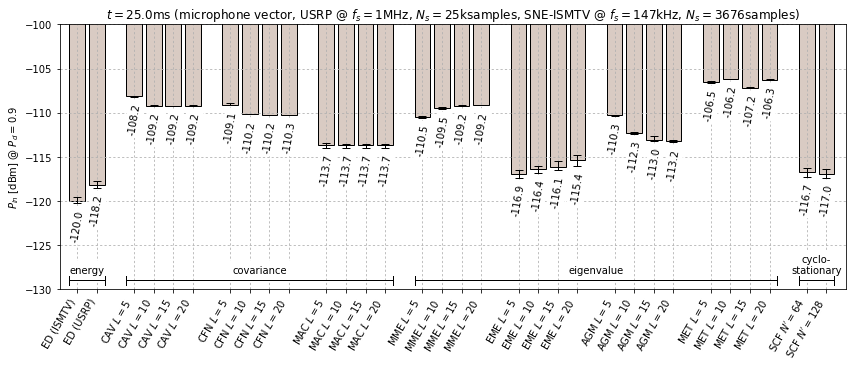

In [21]:
Pinmin_permethod_25ms = get_batch_Pinmin_permethod("../measurements/pd/usrp/sim_usrp_micsoft_fs1mhz_Ns25ks_*.dat")
#Pinmin_permethod_25ms = get_batch_Pinmin_permethod("../simout-usrp-mic-bpsk-20180421-micsoft/dat/sim_usrp_micsoft_fs1mhz_Ns25ks_*.dat")
Pinmin_permethod_25ms['ismtv'] = get_Pinmin("../measurements/pd/sneismtv/sim_sneismtv_micsoft_fs0mhz_Ns3ks_ed_n3676_*.dat")
#Pinmin_permethod_25ms['ismtv'] = get_Pinmin("../simout-sneismtv-mic-bpsk-20180421/dat/sim_sneismtv_micsoft_fs0mhz_Ns3ks_ed_n3676_*.dat")

plot_comparisson(Pinmin_permethod_25ms)
title("$t=25.0$ms (microphone vector, USRP @ $f_s=1$MHz, $N_s=25$ksamples, SNE-ISMTV @ $f_s=147$kHz, $N_s=3676$samples)");

#savefig("figures/pin_min_comparison_25ms.png", dpi=300)
savefig("pin_min_comparison_25ms_micsoft.eps")
None

With a higher sampling rate, performance seems to decrease. Probably because less of the signal is covered with 25.000 samples.

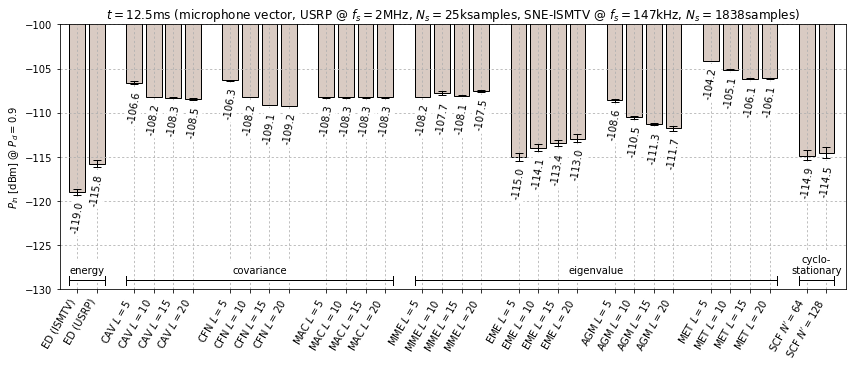

In [22]:
Pinmin_permethod_13ms = get_batch_Pinmin_permethod("../measurements/pd/usrp/sim_usrp_micsoft_fs2mhz_Ns25ks_*.dat")
#Pinmin_permethod_13ms = get_batch_Pinmin_permethod("../simout-usrp-mic-bpsk-20180421-micsoft/dat/sim_usrp_micsoft_fs2mhz_Ns25ks_*.dat")
Pinmin_permethod_13ms['ismtv'] = get_Pinmin("../measurements/pd/sneismtv/sim_sneismtv_micsoft_fs0mhz_Ns3ks_ed_n1838_*.dat")
#Pinmin_permethod_13ms['ismtv'] = get_Pinmin("../simout-sneismtv-mic-bpsk-20180421/dat/sim_sneismtv_micsoft_fs0mhz_Ns3ks_ed_n1838_*.dat")

plot_comparisson(Pinmin_permethod_13ms)
title("$t=12.5$ms (microphone vector, USRP @ $f_s=2$MHz, $N_s=25$ksamples, SNE-ISMTV @ $f_s=147$kHz, $N_s=1838$samples)");

#savefig("figures/pin_min_comparison_13ms.png", dpi=300)
savefig("pin_min_comparison_13ms_micsoft.eps")
None

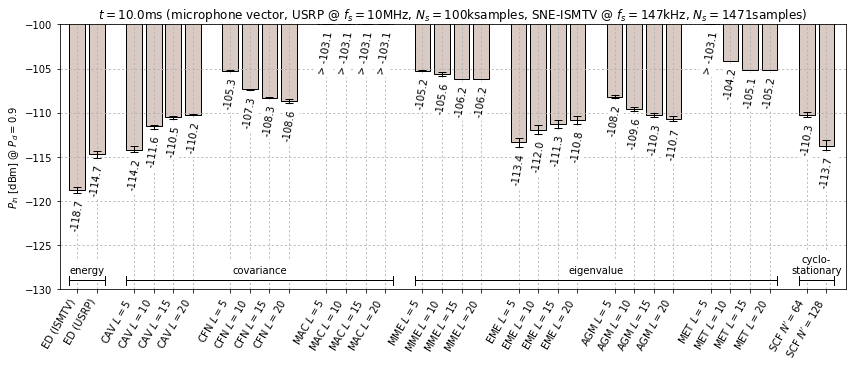

In [23]:
Pinmin_permethod_10ms = get_batch_Pinmin_permethod("../measurements/pd/usrp/sim_usrp_micsoft_fs10mhz_Ns100ks_*.dat")
#Pinmin_permethod_10ms = get_batch_Pinmin_permethod("../simout-usrp-mic-bpsk-20180421-micsoft/dat/sim_usrp_micsoft_fs10mhz_Ns100ks_*.dat")
Pinmin_permethod_10ms['ismtv'] = get_Pinmin("../measurements/pd/sneismtv/sim_sneismtv_micsoft_fs0mhz_Ns3ks_ed_n1471_*.dat")
#Pinmin_permethod_10ms['ismtv'] = get_Pinmin("../simout-sneismtv-mic-bpsk-20180421/dat/sim_sneismtv_micsoft_fs0mhz_Ns3ks_ed_n1471_*.dat")

plot_comparisson(Pinmin_permethod_10ms)
title("$t=10.0$ms (microphone vector, USRP @ $f_s=10$MHz, $N_s=100$ksamples, SNE-ISMTV @ $f_s=147$kHz, $N_s=1471$samples)");

#savefig("figures/pin_min_comparison_10ms.png", dpi=300)
savefig("pin_min_comparison_10ms_micsoft.eps")
None

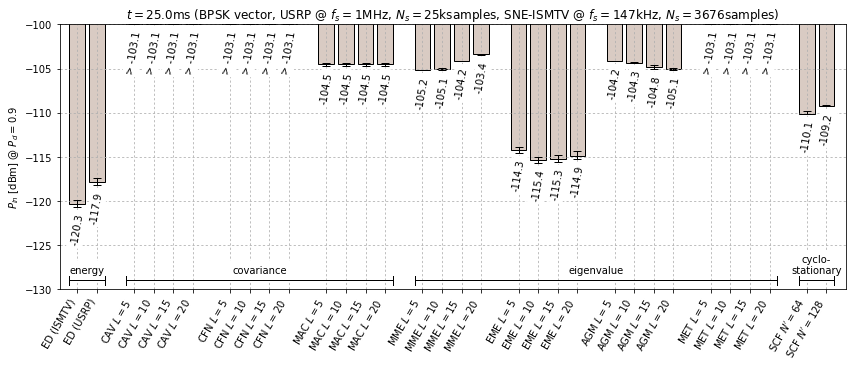

In [24]:
Pinmin_permethod_25ms_bpsk = get_batch_Pinmin_permethod("../measurements/pd/usrp/sim_usrp_bpsk_fs1mhz_Ns25ks_*.dat")
#Pinmin_permethod_25ms_bpsk = get_batch_Pinmin_permethod("../simout-usrp-mic-bpsk-20180414-test-bpsk/dat/sim_usrp_bpsk_fs1mhz_Ns25ks_*.dat")
Pinmin_permethod_25ms_bpsk['ismtv'] = get_Pinmin("../measurements/pd/sneismtv/sim_sneismtv_bpsk_fs0mhz_Ns3ks_ed_n3676_*.dat")
#Pinmin_permethod_25ms_bpsk['ismtv'] = get_Pinmin("../simout-sneismtv-mic-bpsk-20180421/dat/sim_sneismtv_bpsk_fs0mhz_Ns3ks_ed_n3676_*.dat")

plot_comparisson(Pinmin_permethod_25ms_bpsk)
title("$t=25.0$ms (BPSK vector, USRP @ $f_s=1$MHz, $N_s=25$ksamples, SNE-ISMTV @ $f_s=147$kHz, $N_s=3676$samples)");

#savefig("figures/pin_min_comparison_25ms.png", dpi=300)
savefig("pin_min_comparison_25ms_bpsk.eps")
None

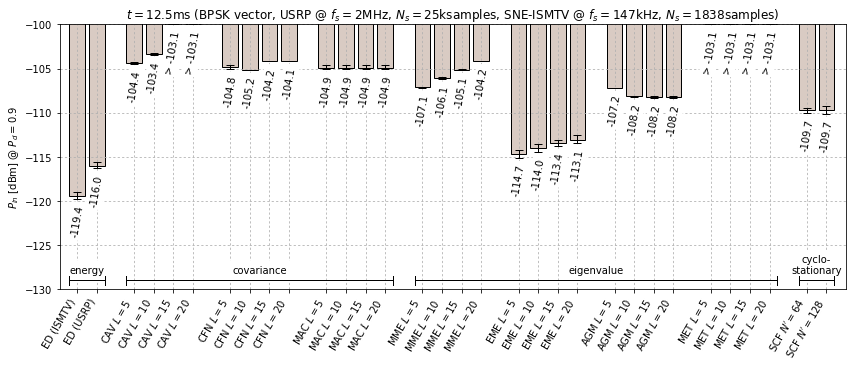

In [25]:
Pinmin_permethod_13ms_bpsk = get_batch_Pinmin_permethod("../measurements/pd/usrp/sim_usrp_bpsk_fs2mhz_Ns25ks_*.dat")
#Pinmin_permethod_13ms_bpsk = get_batch_Pinmin_permethod("../simout-usrp-mic-bpsk-20180414-test-bpsk/dat/sim_usrp_bpsk_fs2mhz_Ns25ks_*.dat")
Pinmin_permethod_13ms_bpsk['ismtv'] = get_Pinmin("../measurements/pd/sneismtv/sim_sneismtv_bpsk_fs0mhz_Ns3ks_ed_n1838_*.dat")
#Pinmin_permethod_13ms_bpsk['ismtv'] = get_Pinmin("../simout-sneismtv-mic-bpsk-20180421/dat/sim_sneismtv_bpsk_fs0mhz_Ns3ks_ed_n1838_*.dat")

plot_comparisson(Pinmin_permethod_13ms_bpsk)
title("$t=12.5$ms (BPSK vector, USRP @ $f_s=2$MHz, $N_s=25$ksamples, SNE-ISMTV @ $f_s=147$kHz, $N_s=1838$samples)");

#savefig("figures/pin_min_comparison_13ms.png", dpi=300)
savefig("pin_min_comparison_13ms_bpsk.eps")
None

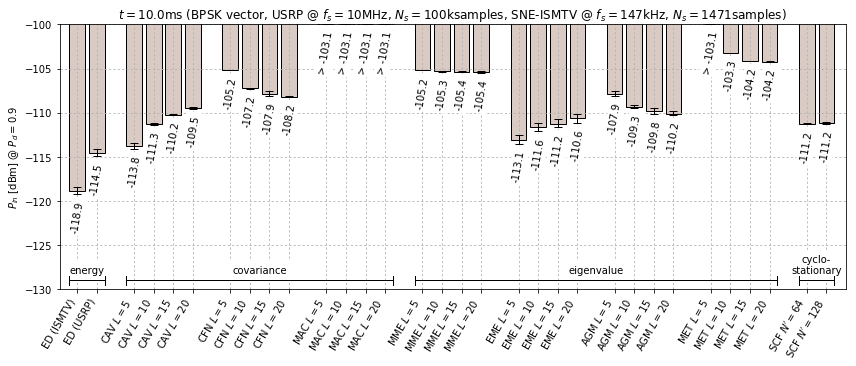

In [26]:
Pinmin_permethod_10ms_bpsk = get_batch_Pinmin_permethod("../measurements/pd/usrp/sim_usrp_bpsk_fs10mhz_Ns100ks_*.dat")
#Pinmin_permethod_10ms_bpsk = get_batch_Pinmin_permethod("../simout-usrp-mic-bpsk-20180414-test-bpsk/dat/sim_usrp_bpsk_fs10mhz_Ns100ks_*.dat")
Pinmin_permethod_10ms_bpsk['ismtv'] = get_Pinmin("../measurements/pd/sneismtv/sim_sneismtv_bpsk_fs0mhz_Ns3ks_ed_n1471_*.dat")
#Pinmin_permethod_10ms_bpsk['ismtv'] = get_Pinmin("../simout-sneismtv-mic-bpsk-20180421/dat/sim_sneismtv_bpsk_fs0mhz_Ns3ks_ed_n1471_*.dat")

plot_comparisson(Pinmin_permethod_10ms_bpsk)
title("$t=10.0$ms (BPSK vector, USRP @ $f_s=10$MHz, $N_s=100$ksamples, SNE-ISMTV @ $f_s=147$kHz, $N_s=1471$samples)");

#savefig("figures/pin_min_comparison_10ms.png", dpi=300)
savefig("pin_min_comparison_10ms_bpsk.eps")
None

### Energy detector

Why such a difference in performance of energy detectors?

- difference in noise figure
- difference in bandwidth

Data for SNE-ISMTV receiver, filter bandwidth and noise figure (from TDA18219HN datasheet)

In [27]:
BWismtv = 1.7e6
NFismtv = 5.5

For USRP, the bandwidth is equal to the sampling frequency.

#### Estimating noise figure for USRP

We don't have a noise figure specification for the SBX daughterboard used on for the USRP measurements. Therefore we estimate it from the schematic.

We gather gain and noise figures of significant elements in the RF line from antenna to the mixer based on the schematic and corresponding component datasheets.

In [28]:
NF_AS225 = 0.3
GL_AS225 = -0.3

NF_MGA82563 = 2.3
GL_MGA82563 = 14.

NF_HMC624 = 15.5
GL_HMC624 = -15.5

NF_ADL5380 = 11.

Convert noise figures to noise factors and gains from logarithmic to linear scale.

In [29]:
def db_to_lin(x):
    return 10.**(x/10.)

def lin_to_db(x):
    return 10.*log10(x)

F_AS225 = db_to_lin(NF_AS225)
G_AS225 = db_to_lin(GL_AS225)

F_MGA82563 = db_to_lin(NF_MGA82563)
G_MGA82563 = db_to_lin(GL_MGA82563)

F_HMC624 = db_to_lin(NF_HMC624)
G_HMC624 = db_to_lin(GL_HMC624)

F_ADL5380 = db_to_lin(NF_ADL5380)

Calculate the composite noise figures using the formula

$F = F_1 + \frac{F_2-1}{G_1} + \frac{F_3 - 1}{G_1 G_2} + \frac{F_4 - 1}{G_1 G_2 G_3} + \cdots + \frac{F_n - 1}{G_1 G_2 G_3 \cdots G_{n-1}}$

In [30]:
Fusrp = F_AS225
Fusrp += (F_MGA82563 - 1) / G_AS225
Fusrp += (F_AS225 - 1) / (G_AS225 * G_MGA82563)
Fusrp += (F_HMC624 - 1) / (G_AS225 * G_MGA82563 * G_AS225)
Fusrp += (F_MGA82563 - 1) / (G_AS225 * G_MGA82563 * G_AS225 * G_HMC624)
Fusrp += (F_ADL5380 - 1) / (G_AS225 * G_MGA82563 * G_AS225 * G_HMC624 * G_MGA82563)

NF_usrp = lin_to_db(Fusrp)
print("NF_usrp = %.1f dB" % (NF_usrp,))

NF_usrp = 7.2 dB


In [31]:
relN_ismtv = ones(3) * 10.*log10(BWismtv) + NFismtv
relN_ismtv

array([ 67.80448921,  67.80448921,  67.80448921])

In [32]:
fs = array([1e6, 2e6, 10e6])
relN_usrp = 10.*log10(fs/2) + NF_usrp
relN_usrp

array([ 64.21565818,  67.22595813,  74.21565818])

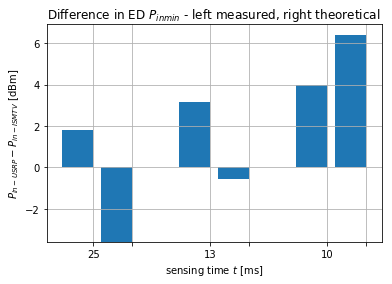

In [33]:
EDdiff = []
EDdiff.append(Pinmin_permethod_25ms['ed'][0] - Pinmin_permethod_25ms['ismtv'][0])
EDdiff.append(Pinmin_permethod_13ms['ed'][0] - Pinmin_permethod_13ms['ismtv'][0])
EDdiff.append(Pinmin_permethod_10ms['ed'][0] - Pinmin_permethod_10ms['ismtv'][0])

left = []
height = []
left1 = 0

for i in range(len(EDdiff)):
    height.append(EDdiff[i])
    left.append(left1)
    left1 += 1
    
    height.append(relN_usrp[i] - relN_ismtv[i])
    left.append(left1)
    left1 += 2
    
left = array(left)

bar(left, height)
xticks(left+.4, ['25', '', '13', '', '10', ''])
xlabel("sensing time $t$ [ms]")
ylabel("$P_{in-USRP} - P_{in-ISMTV}$ [dBm]")

title("Difference in ED $P_{inmin}$ - left measured, right theoretical")

grid()

nan nan


/home/avian/src/jupyter/venv/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in log10


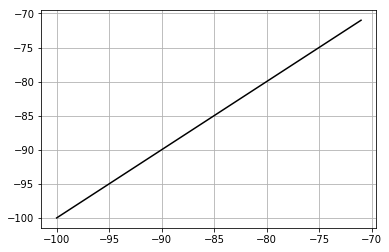

In [34]:
def get_gamma(path):
    Pg = []
    gamma = []
    
    for Pg1, gamma1 in iterate_campaign(path):
        Pg.append(Pg1)
        gamma.append(mean(gamma1))
            
    Pg = array(Pg)
    gamma = array(gamma)
    
    i = Pg.argsort(); gamma = gamma[i]; Pg = Pg[i]
    
    return Pg, gamma

Pg, gamma = get_gamma("../measurements/pd/usrp/sim_usrp_micsoft_fs1mhz_Ns25ks_ed_*.dat")

#print Pg, gamma

gammalog = log10(gamma[2:] - gamma[1])
Pg1 = Pg[2:]

A = np.vstack([Pg1, np.ones(len(Pg1))]).T
m, c = np.linalg.lstsq(A, gammalog)[0]

#plot(Pg1, gammalog, 'o-')
plot(Pg, (log10(gamma) - c)/m, 'o')
plot(Pg, Pg, 'k')

print(m, c)


#Pg, gamma = get_gamma("../measurements/pd/sneismtv/sneismtv_micsoft_fs0mhz_Ns3ks_ed_n1471_*.dat")
#
#gammalog = log10(gamma[1:] - gamma[0])
#Pg1 = Pg[1:]

#A = np.vstack([Pg1, np.ones(len(Pg1))]).T
#m, c = np.linalg.lstsq(A, gammalog)[0]

#plot(Pg, (log10(gamma) - c)/m, 'o')

grid()

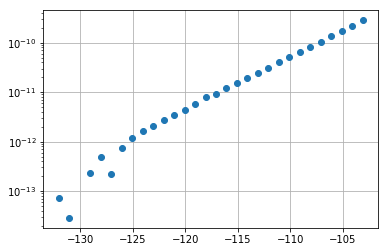

In [35]:
Pin = []
g = []

for Pg, gamma in iterate_campaign("../measurements/pd/sneismtv/sim_sneismtv_micsoft_fs0mhz_Ns3ks_ed_n1471_*.dat"):
    Pin.append(Pg-Att)
    g.append(mean(gamma))

semilogy(Pin, g-min(g), 'o')
grid();

## Resistance of methods to non-constant noise floor

ARB function on SMBV was used to transmit noise with variying power. This noise added to the inherent noise of the USRP, simulating different levels of receiver and ambiental noise.

Noise level was compared to the noise of the receiver using the energy detector:

In [36]:
def get_noise_ratio(path):
    gamma_ed = loadtxt(path.replace("*", "off"))
    EDref = sum(gamma_ed)
    
    Pg = []
    ratio = []
    
    for Pg0, gamma in iterate_campaign(path):
        Pg.append(Pg0)
        
        ED = sum(gamma)
        ratio.append(10*log10(ED/EDref))
                  
    Pg = array(Pg)
    ratio = array(ratio)
    
    Pga = Pg.argsort()
    ratio = ratio[Pga]
    Pg = Pg[Pga]
    
    return Pg, ratio

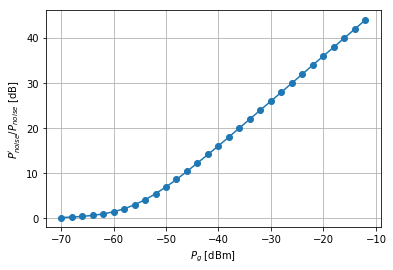

In [37]:
Pg, ratio = get_noise_ratio("../measurements/pd/usrp/sim_usrp_noise_fs1mhz_Ns25ks_ed_*.dat")
plot(Pg, ratio, 'o-')
xlabel("$P_g$ [dBm]")
ylabel("$P_{noise}'/P_{noise}$ [dB]")
grid()

We now compare the probability of false alarm $P_{fa}$ for different levels of noise.

For example, for energy detector:

In [38]:
def get_noise_threshold(path, ratio, Pfath = 2*Pfa):
    gammaN = loadtxt(path.replace("*", "off"))
    gamma0 = get_gamma0(gammaN)
    
    Pin, Pd = get_campaign(path, gamma0)
    
    ratio_max = interp(Pfath, Pd[:,0], ratio)
    u = interp(Pfath, Pd[:,2], ratio)
    v = interp(Pfath, Pd[:,1], ratio)
    
    return ratio_max, u, v
   
def plot_noise_threshold(path, ratio):
    gammaN = loadtxt(path.replace("*", "off"))
    gamma0 = get_gamma0(gammaN)
    
    Pin, Pd = get_campaign(path, gamma0)
    
    ratio_max, u, v = get_noise_threshold(path, ratio)
    print("ratio_max = %f (%f - %f)" % (ratio_max, u, v))

    plot(ratio, Pd[:,0], 'o-')
    fill_between(ratio, Pd[:,1], Pd[:,2], edgecolor='none', alpha=.3)
    
    x1, x2, y1, y2 = axis()
    plot([x1, x2], [2*Pfa, 2*Pfa], 'b--')
    plot([ratio_max, ratio_max], [0, 1], 'b--')
    xlabel("$P_{noise}'/P_{noise}$ [dB]")
    ylabel("$P_{fa}'$")
    grid()

ratio_max = 0.153432 (0.153432 - 0.153432)


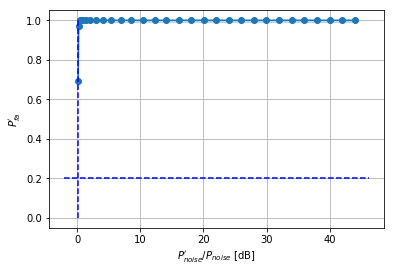

In [39]:
plot_noise_threshold("../measurements/pd/usrp/sim_usrp_noise_fs1mhz_Ns25ks_ed_*.dat", ratio)

And for EME:

ratio_max = 0.617278 (0.248803 - 0.785334)


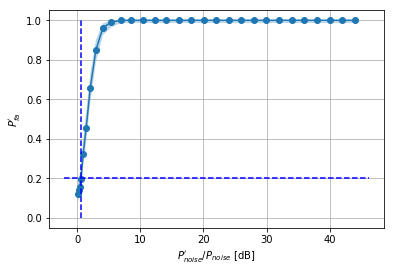

In [40]:
plot_noise_threshold("../measurements/pd/usrp/sim_usrp_noise_fs1mhz_Ns25ks_eme_l20_*.dat", ratio)

In [41]:
def get_batch_noise_threshold_permethod(path):
    
    Pg, ratio = get_noise_ratio(path.replace("*", "ed_*"))
    
    ratio_max_permethod = {}
    for method_p in method_ps:
        path2 = path.replace("*", "%s_*" % (method_p,))
        
        try:
            ratio_max_permethod[method_p] = get_noise_threshold(path2, ratio)
        except IOError:
            pass
        
    return ratio_max_permethod

In [42]:
def plot_noise_comparisson(path, noisecomp=False):
    ratio_max_permethod = get_batch_noise_threshold_permethod(path)
    
    Pg, ratio = get_noise_ratio(path.replace("*", "ed_*"))
    ratio_limit = max(ratio)
    
    plot_noise_comparisson_(ratio_max_permethod, ratio_limit, noisecomp)        

def plot_noise_comparisson_(ratio_max_permethod, ratio_limit, noisecomp):

    cmap = cm.get_cmap('gist_rainbow')

    left = []
    yerr = [[], []]
    height = []
    labels = []
    colors = []

    methods = [#'ed', 'scf', 
            'cav', 'cfn', 'mac', 'mme', 'eme', 'agm', 'met']

    left1 = 0.
    for n, method in enumerate(methods):
        if method == 'ed':
            method_ps = [method]
        elif method == 'scf':
            method_ps = ["scf_Np%d" % scfNp for scfNp in [64, 128]]
        else:
            if noisecomp:
                # compensated detectors
                method_ps = [ "c%s_l%d" % (method, l) for l in range(5, 25, 5) ]
            else:
                # uncompensated detectors
                method_ps = [ "%s_l%d" % (method, l) for l in range(5, 25, 5) ]
        
        for m, method_p in enumerate(method_ps):
            ratio_max, u, v = ratio_max_permethod[method_p]
        
            left.append(left1)
            height.append(ratio_max)
            yerr[0].append(ratio_max-u)
            yerr[1].append(v-ratio_max)
        
            label = method_p.upper()
            label = re.sub("C(\w\w\w)_L", r"\1_L", label)
            label = label.replace("_L", " L=")
            label = re.sub("_NP(\d+)", r" $N'=\1$", label)
            labels.append(label)
        
            c = cmap(float(n)/(len(methods)-1) + m*.007)
            
            # color
            #colors.append(c)
            
            # BW
            #colors.append((.85,.85,.85))
            colors.append((0.851, 0.796, 0.765))
            
            left1 += 1.
        
        left1 += .9
    
    height = array(height)
    left = array(left)

    figure(figsize=(12, 5))
    
    if noisecomp:
        for x, y, e in zip(left, height, yerr[1]):
            text(x+.4, y+e+.4, "%.1f" % y, horizontalalignment="center", rotation=80, backgroundcolor='w')
            
        # legend
        llabels = [[0,12,"covariance\n(with noise compensation)"], 
                 [12,28,"eigenvalue\n(with noise compensation)"]]

        yi = 3.75
        for si, ei, label in llabels:

            x1 = left[si]
            x2 = left[ei-1]+.8

            plot([x1,x2], [yi,yi], 'k', lw=1)
            plot([x1,x1], [yi-.1,yi+.1], 'k', lw=1)
            plot([x2,x2], [yi-.1,yi+.1], 'k', lw=1)

            text((x1+x2)/2., yi-.35, label, horizontalalignment="center", backgroundcolor='w')
    
    bw = .8
    bar(left+bw/2, height, color=colors, width=bw, bottom=0, lw=1, ls='solid', ec='k')
    errorbar(left+bw/2, height, yerr=yerr, ls='none', color='k', capsize=4., lw=1)
    
    plot([-.5, left1-.5], [ratio_limit, ratio_limit], 'k-')
    xticks(left+bw/2, labels, rotation=60, horizontalalignment='right')
    #ylabel("$P_{noise}'/P_{noise}$ [dB] @ $P_{fa}' = 2 P_{fa}$")
    ylabel("$\Delta P_{noise}$ [dB] @ $P_{fa} = 0.2$")
    
    if noisecomp:
        ylim(0, 4)
    else:
        ylim(0, 20)
    xlim(-.5, left1-.5)
    tight_layout()
    grid(ls=':')

**Higher is better**

Black line shows the maximum noise level tested. If the bar reaches it, $P_{fa}'$ was never over the threshold.

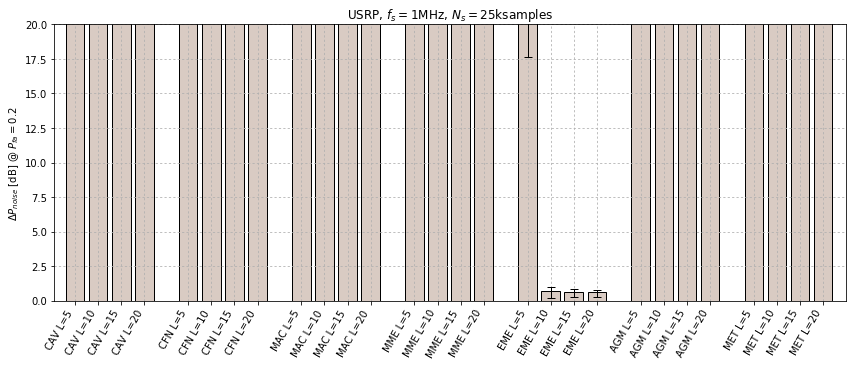

In [43]:
plot_noise_comparisson("../measurements/pd/usrp/sim_usrp_noise_fs1mhz_Ns25ks_*.dat")
#plot_noise_comparisson("../simout-20161105-usrp_campaign_noise_noisecomp/dat/sim_usrp_noise_fs1mhz_Ns25ks_*.dat")
title("USRP, $f_s=1$MHz, $N_s=25$ksamples");

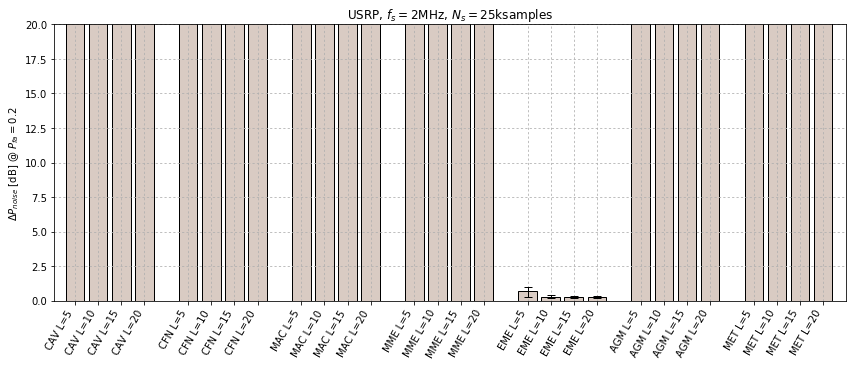

In [44]:
plot_noise_comparisson("../measurements/pd/usrp/sim_usrp_noise_fs2mhz_Ns25ks_*.dat")
#plot_noise_comparisson("../simout-20161105-usrp_campaign_noise_noisecomp/dat/sim_usrp_noise_fs2mhz_Ns25ks_*.dat")
title("USRP, $f_s=2$MHz, $N_s=25$ksamples");

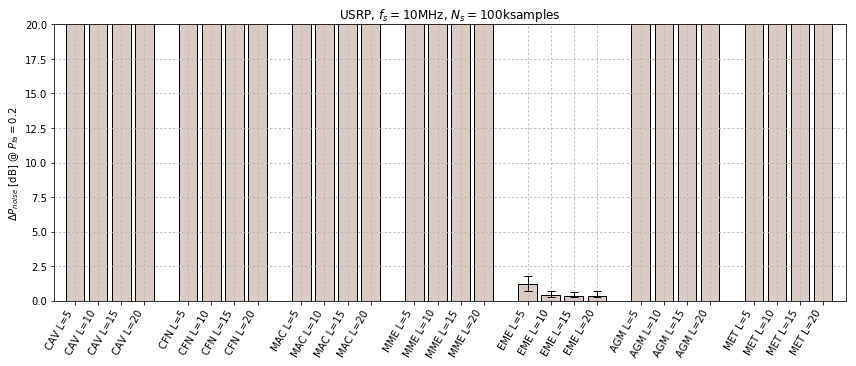

In [45]:
plot_noise_comparisson("../measurements/pd/usrp/sim_usrp_noise_fs10mhz_Ns100ks_*.dat")
#plot_noise_comparisson("../simout-20161105-usrp_campaign_noise_noisecomp/dat/sim_usrp_noise_fs10mhz_Ns100ks_*.dat")
title("USRP, $f_s=10$MHz, $N_s=100$ksamples");

In [46]:
def table_noise_comparisson():
    paths = ["../measurements/pd/usrp/sim_usrp_noise_fs1mhz_Ns25ks_*.dat",
             "../measurements/pd/usrp/sim_usrp_noise_fs2mhz_Ns25ks_*.dat",
             "../measurements/pd/usrp/sim_usrp_noise_fs10mhz_Ns100ks_*.dat" ]
    
    ratio_max_permethod_perpath = []
    
    for path in paths:
        ratio_max_permethod = get_batch_noise_threshold_permethod(path)
        ratio_max_permethod_perpath.append(ratio_max_permethod)
            
    Pg, ratio = get_noise_ratio(path.replace("*", "ed_*"))
    ratio_limit = max(ratio)
    
    table_noise_comparisson_(ratio_max_permethod_perpath, ratio_limit)

def table_noise_comparisson_(ratio_max_permethod_perpath, ratio_limit):

    methods = ['ed', 'cav', 'cfn', 'mac', 'mme', 'eme', 'agm', 'met']

    left1 = 0.
    for n, method in enumerate(methods):
        if method == 'ed':
            method_ps = [method]
        else:
            method_ps = [ "%s_l%d" % (method, l) for l in range(5, 25, 5) ]
            
        print("\hline")
        
        for m, method_p in enumerate(method_ps):
            label = method_p.upper()
            label = re.sub("_L(\d+)", r" $L=\1$", label)
            
            print("%s" % (label,))
            
            for ratio_max_permethod in ratio_max_permethod_perpath:
                ratio_max = ratio_max_permethod[method_p][0]
            
                if ratio_max > 40.:
                    ratio_max_fmt = ">40.0"
                else:
                    ratio_max_fmt = "\mathbf{%.1f}" % ratio_max
            
                print("& $%s$" % (ratio_max_fmt,))
                
            print("\\\\")

In [47]:
table_noise_comparisson()

\hline
ED
& $\mathbf{0.2}$
& $\mathbf{0.2}$
& $\mathbf{0.2}$
\\
\hline
CAV $L=5$
& $>40.0$
& $>40.0$
& $>40.0$
\\
CAV $L=10$
& $>40.0$
& $>40.0$
& $>40.0$
\\
CAV $L=15$
& $>40.0$
& $>40.0$
& $>40.0$
\\
CAV $L=20$
& $>40.0$
& $>40.0$
& $>40.0$
\\
\hline
CFN $L=5$
& $>40.0$
& $>40.0$
& $>40.0$
\\
CFN $L=10$
& $>40.0$
& $>40.0$
& $>40.0$
\\
CFN $L=15$
& $>40.0$
& $>40.0$
& $>40.0$
\\
CFN $L=20$
& $>40.0$
& $>40.0$
& $>40.0$
\\
\hline
MAC $L=5$
& $>40.0$
& $>40.0$
& $>40.0$
\\
MAC $L=10$
& $>40.0$
& $>40.0$
& $>40.0$
\\
MAC $L=15$
& $>40.0$
& $>40.0$
& $>40.0$
\\
MAC $L=20$
& $>40.0$
& $>40.0$
& $>40.0$
\\
\hline
MME $L=5$
& $>40.0$
& $>40.0$
& $>40.0$
\\
MME $L=10$
& $>40.0$
& $>40.0$
& $>40.0$
\\
MME $L=15$
& $>40.0$
& $>40.0$
& $>40.0$
\\
MME $L=20$
& $>40.0$
& $>40.0$
& $>40.0$
\\
\hline
EME $L=5$
& $\mathbf{35.9}$
& $\mathbf{0.7}$
& $\mathbf{1.2}$
\\
EME $L=10$
& $\mathbf{0.7}$
& $\mathbf{0.3}$
& $\mathbf{0.4}$
\\
EME $L=15$
& $\mathbf{0.6}$
& $\mathbf{0.2}$
& $\mathbf{0.4}$
\\
EME $L

## Effect of noise compensation on covariance-based detection

When we turn on noise compensation with covariance (and eigenvalue) methods, their $P_{inmin}$ decreases. This is expected, since $\gamma$ is now insensitive to correlations in the internal USRP noise.

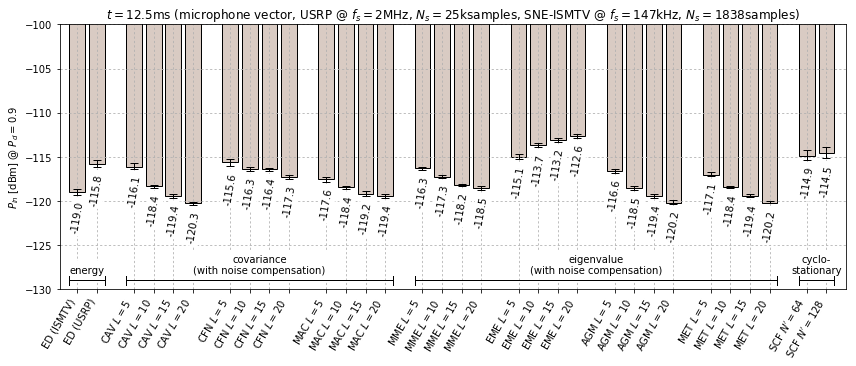

In [48]:
Pinmin_permethod_13ms = get_batch_Pinmin_permethod("../measurements/pd/usrp/sim_usrp_micsoft_fs2mhz_Ns25ks_*.dat")
Pinmin_permethod_13ms['ismtv'] = get_Pinmin("../measurements/pd/sneismtv/sim_sneismtv_micsoft_fs0mhz_Ns3ks_ed_n1838_*.dat")

plot_comparisson(Pinmin_permethod_13ms, noisecomp=True)
title("$t=12.5$ms (microphone vector, USRP @ $f_s=2$MHz, $N_s=25$ksamples, SNE-ISMTV @ $f_s=147$kHz, $N_s=1838$samples)");

#savefig("figures/pin_min_comparison_13ms.png", dpi=300)
savefig("pin_min_comparison_13ms_noisecomp.eps")
None

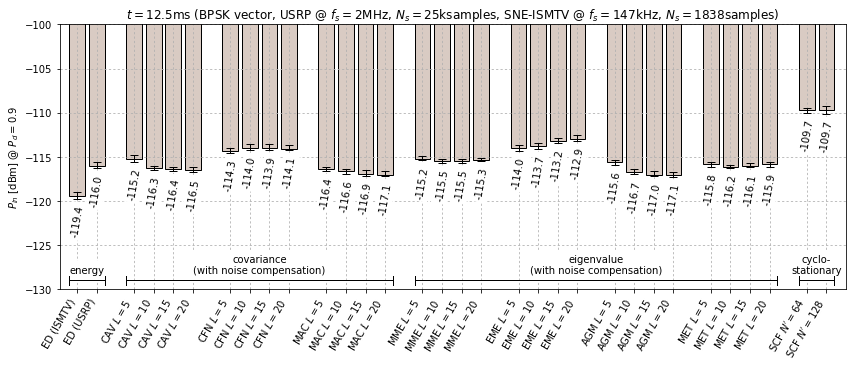

In [49]:
Pinmin_permethod_13ms = get_batch_Pinmin_permethod("../measurements/pd/usrp/sim_usrp_bpsk_fs2mhz_Ns25ks_*.dat")
Pinmin_permethod_13ms['ismtv'] = get_Pinmin("../measurements/pd/sneismtv/sim_sneismtv_bpsk_fs0mhz_Ns3ks_ed_n1838_*.dat")

plot_comparisson(Pinmin_permethod_13ms, noisecomp=True)
title("$t=12.5$ms (BPSK vector, USRP @ $f_s=2$MHz, $N_s=25$ksamples, SNE-ISMTV @ $f_s=147$kHz, $N_s=1838$samples)");

#savefig("figures/pin_min_comparison_13ms.png", dpi=300)
savefig("pin_min_comparison_13ms_noisecomp_bpsk.eps")
None

However, compensation also makes these methods sensitive to variations in the external Gaussian noise. Since Gaussian noise after compensation is no longer white, compensated methods are very sensitive to its level. Hence, most methods are now just as sensitive to noise variations as energy detection!

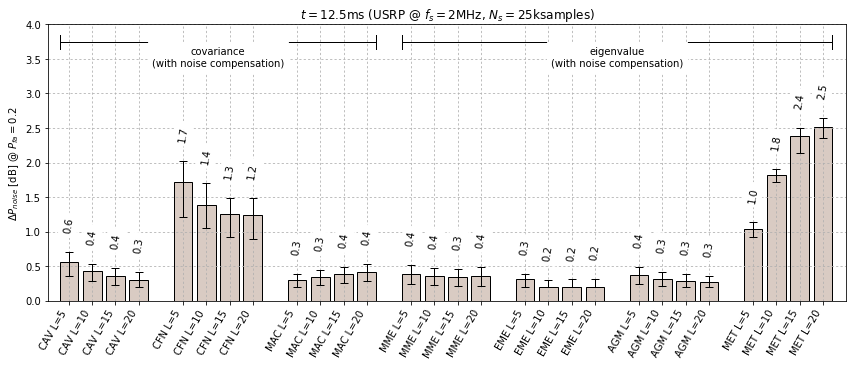

In [50]:
plot_noise_comparisson("../measurements/pd/usrp/sim_usrp_noise_fs2mhz_Ns25ks_*.dat", noisecomp=True)
title("$t=12.5$ms (USRP @ $f_s=2$MHz, $N_s=25$ksamples)")
savefig("dpnoise_comparison_13ms_noisecomp.eps")